In [1]:
from keras.layers import Input, Dense, Flatten, Reshape
from sklearn.feature_extraction import image as sk_image
from concurrent.futures import ProcessPoolExecutor
from keras.models import Model
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import convolve2d 
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from pyhdf.SD import SD, SDC
import matplotlib as mpl
#tf.config.threading.set_inter_op_parallelism_threads(1)
from extract_training_data import *
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from pyhdf.error import HDF4Error
from functions import *


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


#bands = [6, 7, 20, 28, 28, 31]


1 Physical GPUs, 1 Logical GPUs


2023-09-18 16:52:48.448458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21336 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:25:00.0, compute capability: 7.5


In [3]:
import importlib
import extract_training_data
importlib.reload(extract_training_data)
from extract_training_data import *
folder = "/uio/hume/student-u37/fslippe/data/nird_mount/MOD02QKM_202012-202104/"

start = "20210321"
end = "20210321"
dates = ["20210321"]
dates_converted = []
for date in dates:
    dates_converted.append(convert_to_day_of_year(date))

start_converted = convert_to_day_of_year(start)
end_converted = convert_to_day_of_year(end)
print(start_converted)
print(end_converted)
x = [xi for xi in  extract_250m_data(folder, bands=[1], date_list=dates_converted, min_mean=0) if xi.shape[0] > 256]
#x = extract_250m_data(folder, bands=[1], start_date=start_converted, end_date=end_converted)
len(x)


2021080
2021080
Preprocess
Date: 20210321


100%|██████| 17/17 [00:05<00:00,  3.37it/s]


16

In [4]:
for i in range(len(x)):
    print(np.mean(x[i]))
    print(x[i].shape)

115.91036192944182
(8120, 5416, 1)
117.89544158641044
(8160, 5416, 1)
63.48798220706515
(1400, 5416, 1)
114.72653770983581
(7320, 5416, 1)
74.161850986486
(3040, 5416, 1)
95.59137425333844
(5880, 5416, 1)
91.21117834255514
(8120, 5416, 1)
119.18298050595502
(8120, 5416, 1)
25.451700476770867
(5200, 5416, 1)
33.39501432675147
(6040, 5416, 1)
51.20310012607275
(2200, 5416, 1)
86.40848105934828
(5040, 5416, 1)
24.759787166556286
(4400, 5416, 1)
70.81329569195569
(6680, 5416, 1)
68.03412862528236
(8120, 5416, 1)
120.5654379739411
(8120, 5416, 1)


In [5]:
import autoencoder
import importlib
importlib.reload(autoencoder)
from autoencoder import SobelFilterLayer, SimpleAutoencoder
bands = [1]
patch_size = 256

autoencoder = SimpleAutoencoder(len(bands), patch_size, patch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model = autoencoder.model(optimizer=optimizer, threshold=0.09,loss="combined")
normalized_data = autoencoder.normalize(x)
#normalized_patches = np.concatenate([autoencoder.extract_patches(n_d) for n_d in normalized_data], axis=0)


Input should already be normalized. Call self.normalize to normalize list of data


In [6]:
from autoencoder import SobelFilterLayer, SimpleAutoencoder
bands = [1]
patch_size = 256
from tensorflow.keras.models import load_model
print(len(bands))
autoencoder_predict = SimpleAutoencoder(len(bands), patch_size, patch_size)

encoder = load_model("/uio/hume/student-u37/fslippe/data/models/test_1day_encoder")

1


In [7]:
# normalized_patches = np.concatenate([autoencoder.extract_patches(n_d) for n_d in normalized_data[:4]], axis=0)

start = 3
index_list = [3,10, 13, 14]
cluster_map_encoded = autoencoder_predict.kmeans([normalized_data[i] for i in index_list], n_clusters=10, encoder=encoder)
gc.collect()


2023-09-18 16:53:03.398729: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202
/uio/hume/student-u37/fslippe/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


2218

In [8]:
cluster_map = []
all_patches = []
starts = []
ends =[]
shapes = []
start = 0 

for image in [normalized_data[i] for i in index_list]:
    shapes.append(image.shape[0:2])
    patches = autoencoder_predict.extract_patches(image)  # Assuming this function extracts and reshapes patches for a single image
    all_patches.append(patches)
    starts.append(start)
    ends.append(start + len(patches))
    start += len(patches)



# Stack filtered patches from all images
patches = np.concatenate(all_patches, axis=0)

patches_flat = patches.reshape(patches.shape[0], -1)
# KMeans clustering
kmeans = KMeans(10).fit(patches_flat)

labels = kmeans.labels_

# Assuming your original data shape is (height, width)
for i in range(len(index_list)):
    height, width = shapes[i]

    # Calculate the dimensions of the reduced resolution array
    reduced_height = height // patch_size
    reduced_width = width // patch_size
    cluster_map.append(np.reshape(labels[starts[i]:ends[i]], (reduced_height, reduced_width)))

gc.collect()


/uio/hume/student-u37/fslippe/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


216

0.24460379310972444
0.10916805091330324
0.15097815269786427
0.14505280343025875


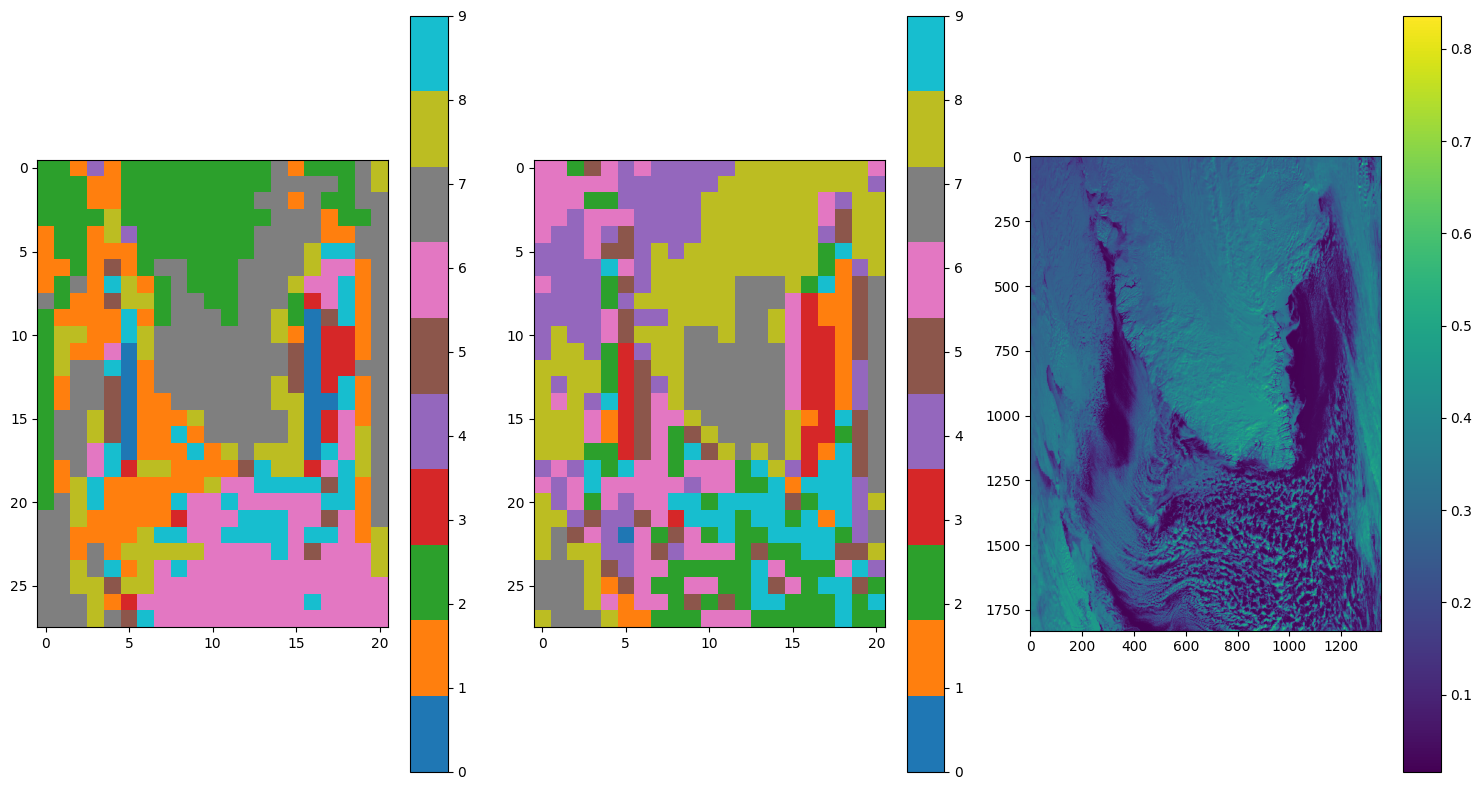

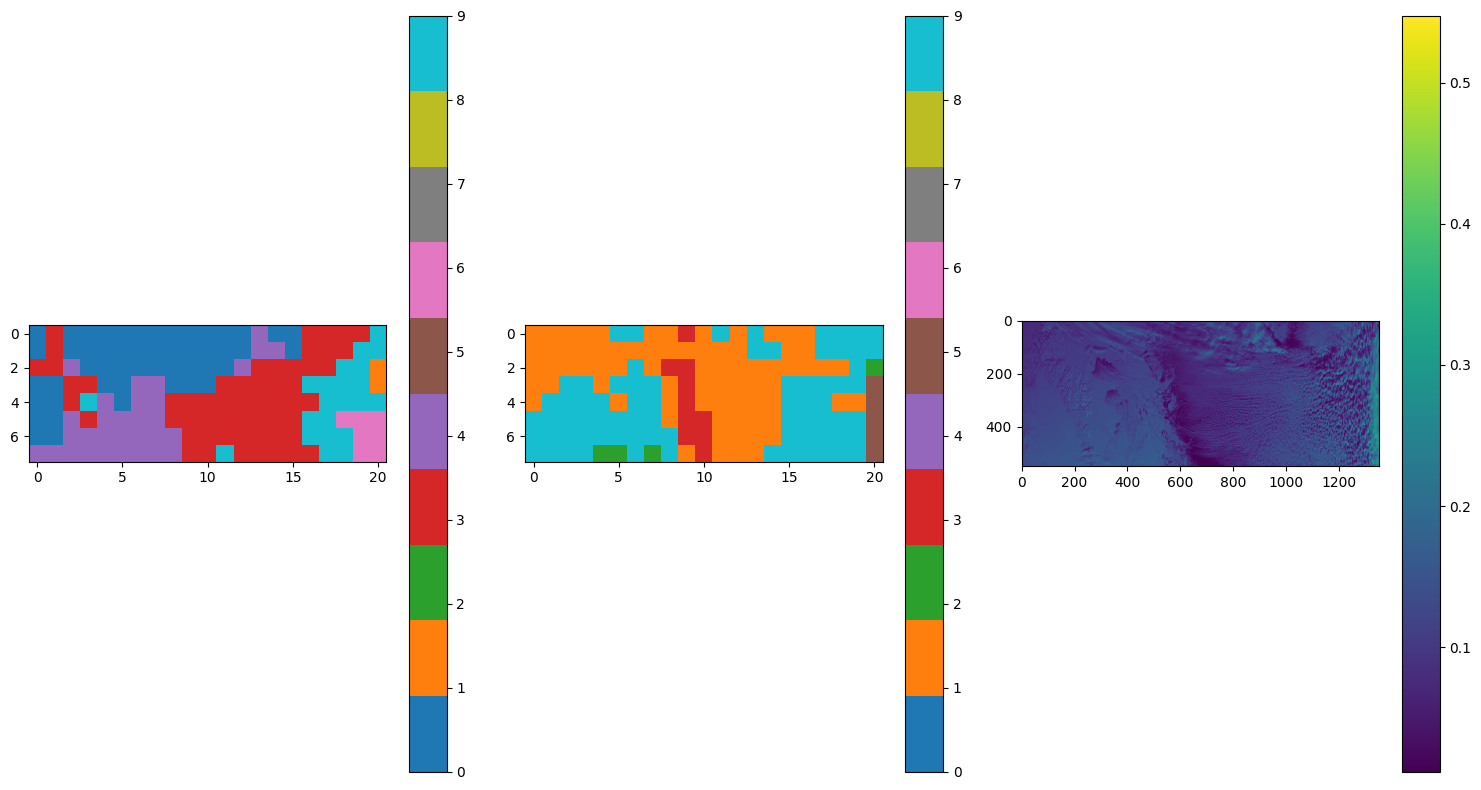

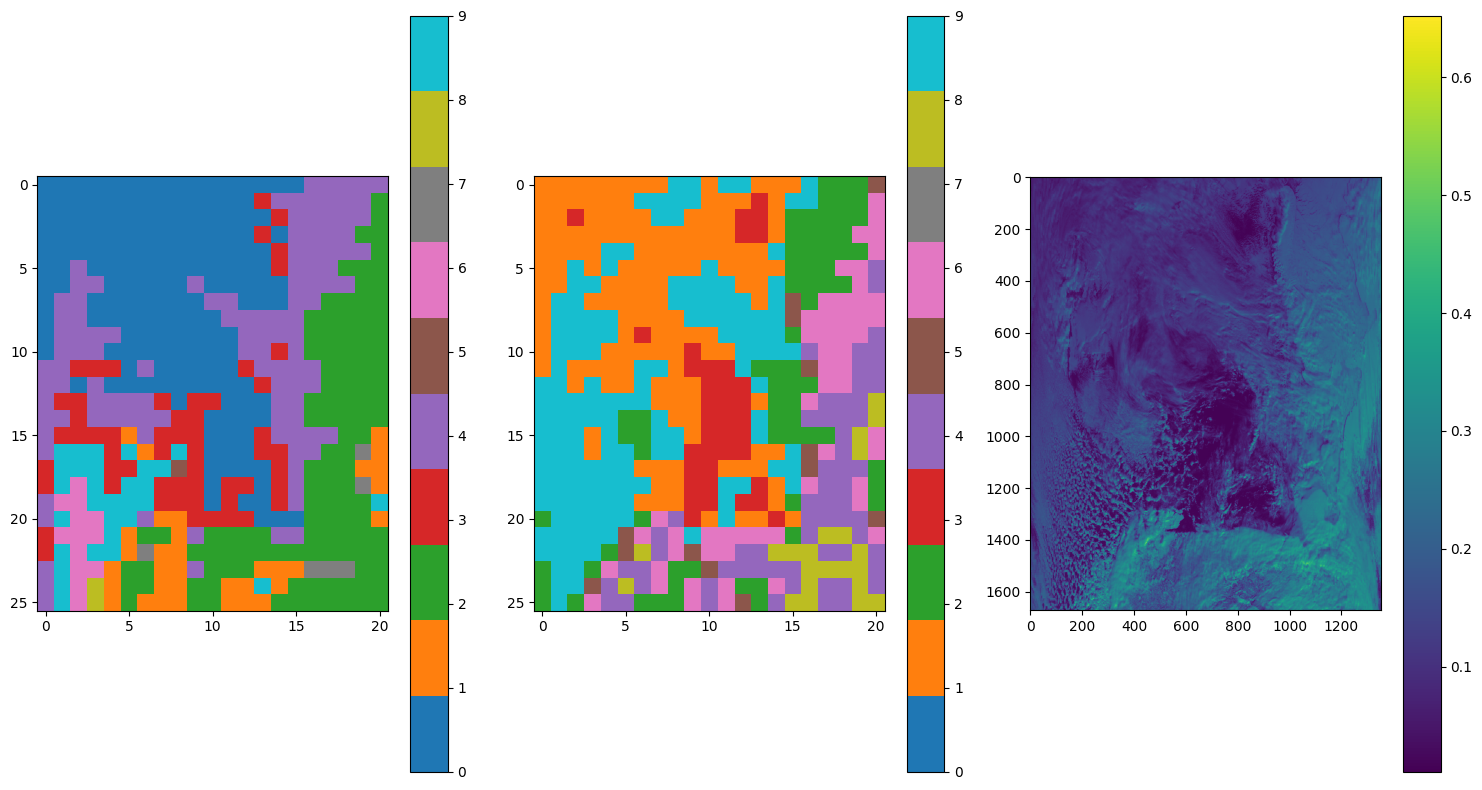

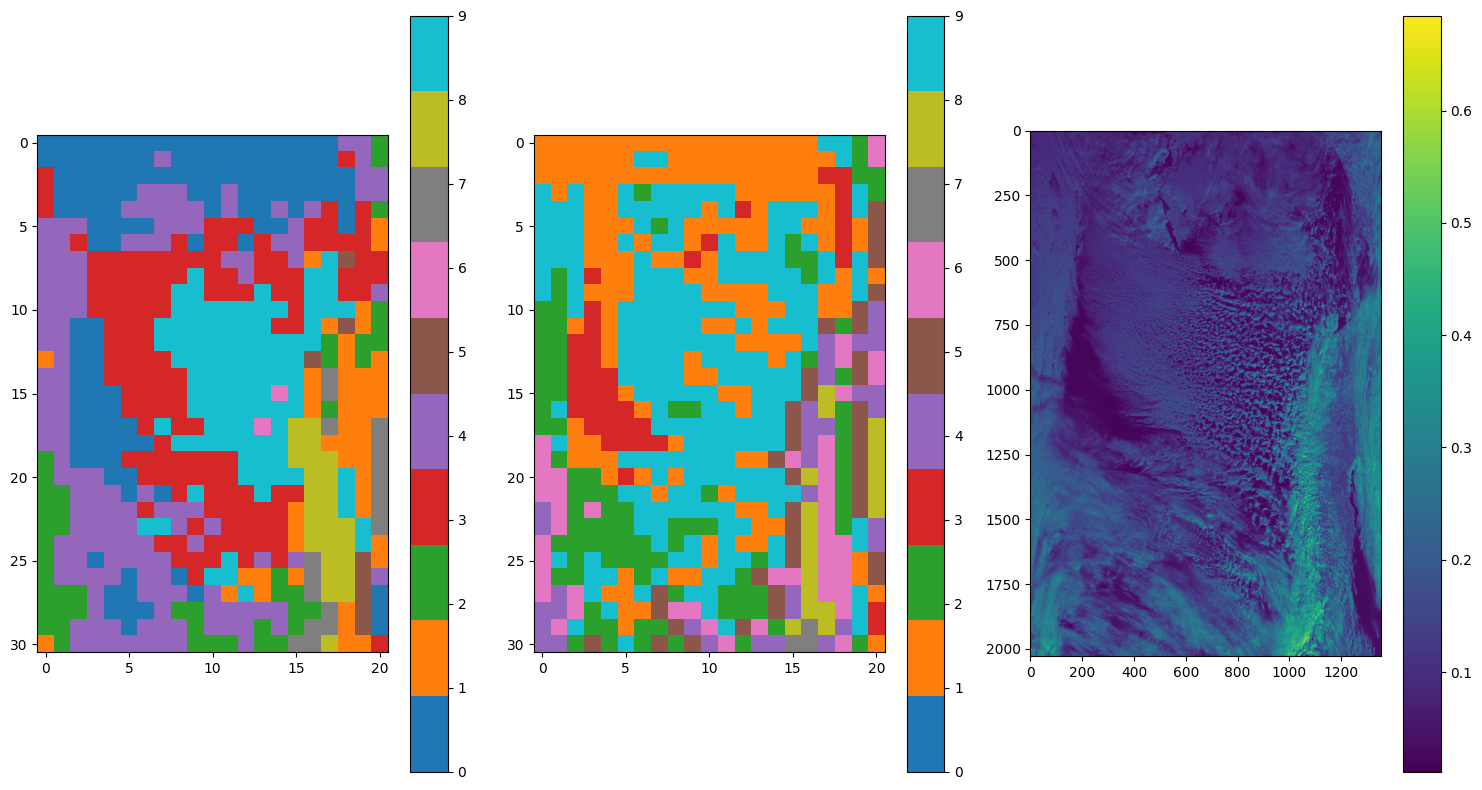

In [9]:
from matplotlib.colors import Normalize

# Determine global min and max labels
global_min = np.min([np.min(cm) for cm in cluster_map])
global_max = np.max([np.max(cm) for cm in cluster_map])

norm = Normalize(vmin=global_min, vmax=global_max)

for i in range(len(cluster_map)):
    fig, axs = plt.subplots(1, 3, figsize=[15, 8])
    print(np.mean(normalized_data[index_list[i]]))
    cb = axs[0].imshow(cluster_map_encoded[i], cmap="tab10", norm=norm)
    plt.colorbar(cb, ax=axs[0])
    cb = axs[1].imshow(cluster_map[i], cmap="tab10", norm=norm)
    plt.colorbar(cb, ax=axs[1])
    
    cb = axs[2].imshow(normalized_data[index_list[i]][::4, ::4, 0])
    plt.colorbar(cb, ax=axs[2])
    plt.tight_layout()